# 4. Graphing the HMI Wavefunctions
## A. Comparison With LCAO

### Setup code

From 3a and 3b, we combine all solution. From now on, D = 2.0.

When

In [1]:
import os
import numpy as np
from numpy import polynomial as P 
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "figure.figsize": [8.0, 5.0]})

try:
    # this may look good for retina display users
    %config InlineBackend.figure_format = 'retina'
except:
    pass

# D = 2, always
D = 2

# Energy values from 3b_solve_R.ipynb
mo_nums = {
    '1 sigma g': (1, 0, 0),
    '1 sigma u *': (1, 0, 1),
    '1 pi u': (1, 1, 1),
    '2 sigma g': (2, 0, 0),
    '2 sigma u *': (2, 0, 1),
    '3 sigma g': (1, 0, 2),
    '1 pi g *': (1, 1, 2),
    '3 sigma u *':(1, 0, 3),
}

E_exact_dict = {
    '1 sigma g': -1.0996287880018977833884719075285829603672027587890625,
    '1 sigma u *': -0.66747226769876011331916743074543774127960205078125,
    '1 pi u': -0.428757630933387978711124333131010644137859344482421875,
    '2 sigma g': -0.360299650543231930743814928064239211380481719970703125,
    '2 sigma u *': -0.255397764046394915027349270530976355075836181640625,
    '3 sigma g': -0.2360276423296774617188731326677952893078327178955078125,
    '1 pi g *': -0.2266979721961866200974355933794868178665637969970703125,
    '3 sigma u *':-0.12664478743642726410456589292152784764766693115234375,
}

def get_lbda(mu, l):
    # retrieve Lambda from file
    filename = f"data_lbda/lbda_{mu}{l}.txt"
    filedir = os.path.join(os.path.abspath(''), filename)
    with open(filedir, 'r') as file:
        lbda_coef = np.loadtxt(file)
    lbda = P.Polynomial(lbda_coef) # a function of c2
    return lbda

def get_R(mu, l, E_exact):
    
    # greater values of l require greater cutoff values
    if l == 0:
        cutoff = 10
    elif l == 1:
        cutoff = 15
    elif l == 2:
        cutoff = 20
    elif l == 3:
        cutoff = 40
    
    c2 = (1/2) * E_exact * (D**2)
    lbda_val = get_lbda(mu, l)(c2)
    
    # initial value of g and g'
    q1 = np.array([1,-(2*D + c2 + mu*(mu+1) - lbda_val)/(2*(mu+1))])
    
    G = lambda xi, q: np.array([[0, 1],
    [-(2*D*xi + c2*(xi**2) + mu*(mu+1) - lbda_val)/(xi**2 - 1),
    -(2*(mu+1)*xi)/(xi**2 - 1)]]) @ q
    
    # solve for g(xi) for 1 < xi <= cutoff
    # exclude xi = 1 to avoid a divide-by-zero error
    xi_span_for_calc = np.linspace(1, cutoff, cutoff*100)
    eps = 1e-10
    xi_span_for_calc[0] = 1 + eps
    
    sol = solve_ivp(G, [1 + eps, cutoff], q1, t_eval=xi_span_for_calc)
    
    # calculate R from g
    R_vals = ((xi_span_for_calc ** 2 - 1)**(mu/2)) * sol.y[0]
    
    # add back xi = 0 and R(xi) = 0 or 1 depending on mu
    xi_span_for_calc[0] = 1
    R_vals[0] = 1 if mu == 0 else 0
    
    R_interp = interp1d(xi_span_for_calc, R_vals, kind='linear')
    
    # NOTE: xi greater than cutoff should result in R = 0
    # to be implemented with functions down the line
    return R_interp, cutoff

def get_S(mu, l, E_exact):
    
    # evenness determined by the number of angular nodes between the two nuclei
    # excluding angular nodes that contain the internuclear axis
    is_even = True if (l - mu) % 2 == 0 else False
    
    c2 = (1/2) * E_exact * (2.0**2)
    lbda_val = get_lbda(mu, l)(c2)

    p1 = np.array([1, ((mu*(mu+1) + c2 - lbda_val)/(2*(mu+1)))])

    F = lambda eta, p: np.array([[0, 1], 
    [(mu*(mu+1) - lbda_val + c2*(eta**2))/(1 - eta**2), 2*(mu+1)*eta/(1 - eta**2)]]) @ p
    
    # obtain values of f(eta) along these points (we exclude eta=1 to avoid a divide-by-zero error)
    eta_span = np.linspace(1, 0, 100)
    eps = 1e-10 # a very small value
    eta_span[0] = 1 - eps

    # solve using solve_ivp, sol.y[0] is f(eta_span) and sol.y[1] is f'(eta_span)
    sol = solve_ivp(F, [1 - eps, 0], p1, t_eval=eta_span)

    # we are plotting S(eta), not f(eta)
    S_vals = ((1 - eta_span**2) ** (mu/2)) * sol.y[0]

    # add back S_val(1) to eta_span
    S_vals[0] == 1 if mu == 0 else 0
    

    if is_even:
        S_vals = np.concatenate([S_vals[:-1], S_vals[::-1]])
    else:
        S_vals = np.concatenate([-S_vals[:-1], S_vals[::-1]])
    
    return interp1d(np.linspace(-1.0, 1.0, 199), S_vals, kind='linear')


# note: D = 2.0
def cart_to_ellip(x, y, z):
    # define point A and B
    cart_coords = np.array([x, y, z])
    pA = np.array([0, 0, -1.0])
    pB = np.array([0, 0, 1.0])
    rA = np.linalg.norm(cart_coords - pA)
    rB = np.linalg.norm(cart_coords - pB)
    
    xi = (rA + rB)/2.0
    nu = (rA - rB)/2.0
    
    # check for bounds
    if xi < 1.0:
        xi = 1.0
    
    if nu < -1.0:
        nu = -1.0
    elif nu > 1.0:
        nu = 1.0
    
    # getting phi to work is tricky
    if cart_coords[0] == 0.0:
        phi = np.pi/2 if cart_coords[1] >= 0 else (3*np.pi)/2
    else:
        phi = np.arctan(cart_coords[1] / cart_coords[0])
        if cart_coords[0] <= 0:
            phi += np.pi
    
    return xi, nu, phi
    

### HOMO and LUMO again

Comparison, 3D surface contour

In [2]:
"""
 Exact MO |  LCAO-MO
 sigma_u     sigma_u_1s 
 sigma_g     sigma_g_1s

All takes cartesian coordinates
"""

from scipy.integrate import quad

# exact mo of mo along the xz-plane
def get_mo_slice(l, E_exact):
    R, cutoff = get_R(0, l, E_exact)
    S = get_S(0, l, E_exact)

    # above needs to be normalized
    # volume element = (xi**2 - eta**2) * d xi * d eta * d phi
    # integration with phi yields norm constant of 2*pi

    S2_int, _ = quad(lambda eta: S(eta)**2, -1.0, 1.0, epsrel=1.0e-5)
    eta2_S2_int, _ = quad(lambda eta: (eta*S(eta))**2, -1.0, 1.0, epsrel=1.0e-5)
    R2_int, _ = quad(lambda xi: R(xi)**2, 1.0, cutoff, epsrel=1.0e-5)
    xi2_R2_int, _ = quad(lambda xi: (xi*R(xi))**2, 1.0, cutoff, epsrel=1.0e-5)


    norm_const = np.sqrt(2*np.pi*(S2_int*xi2_R2_int + eta2_S2_int*R2_int))

    def mo_returned(x, z):
        rA = np.sqrt(x**2 + (z + 1.0)**2)
        rB = np.sqrt(x**2 + (z - 1.0)**2)
        
        xi = (rA + rB)/2.0
        eta = (rA - rB)/2.0
        
        # check for bounds
        if xi < 1.0:
            xi = 1.0
        
        if eta < -1.0:
            eta = -1.0
        elif eta > 1.0:
            eta = 1.0
        
        # because we work with sigma orbitals only
        # we do not deal with phi

        # xi greater than the cutoff value -> R = 0
        # implemented here
        if xi > cutoff:
            return 0
        else:
            return (R(xi)*S(eta))/norm_const

    return mo_returned

# exact mo of mo along the xz-plane
# l == 0: bonding, l == 1: antibonding
def get_lcao_slice(l):
    # 1s orbital, function of r only
    s_orbital = lambda r: np.exp(-r)/np.sqrt(np.pi)

    def lcao_returned(x, z, l):
        rA = np.sqrt(x**2 + (z + 1.0)**2)
        rB = np.sqrt(x**2 + (z - 1.0)**2)

        # normalization constants from literature
        S_2 = np.exp(-2.0) * (1 + 2.0 + (2.0**2)/3)
        
        
        if l == 0: # bonding
            return (s_orbital(rB) + s_orbital(rA))/np.sqrt(2 * (1 + S_2))
        else: # antibonding
            return (s_orbital(rB) - s_orbital(rA))/np.sqrt(2 * (1 - S_2))

    return lambda x, z: lcao_returned(x, z, l)

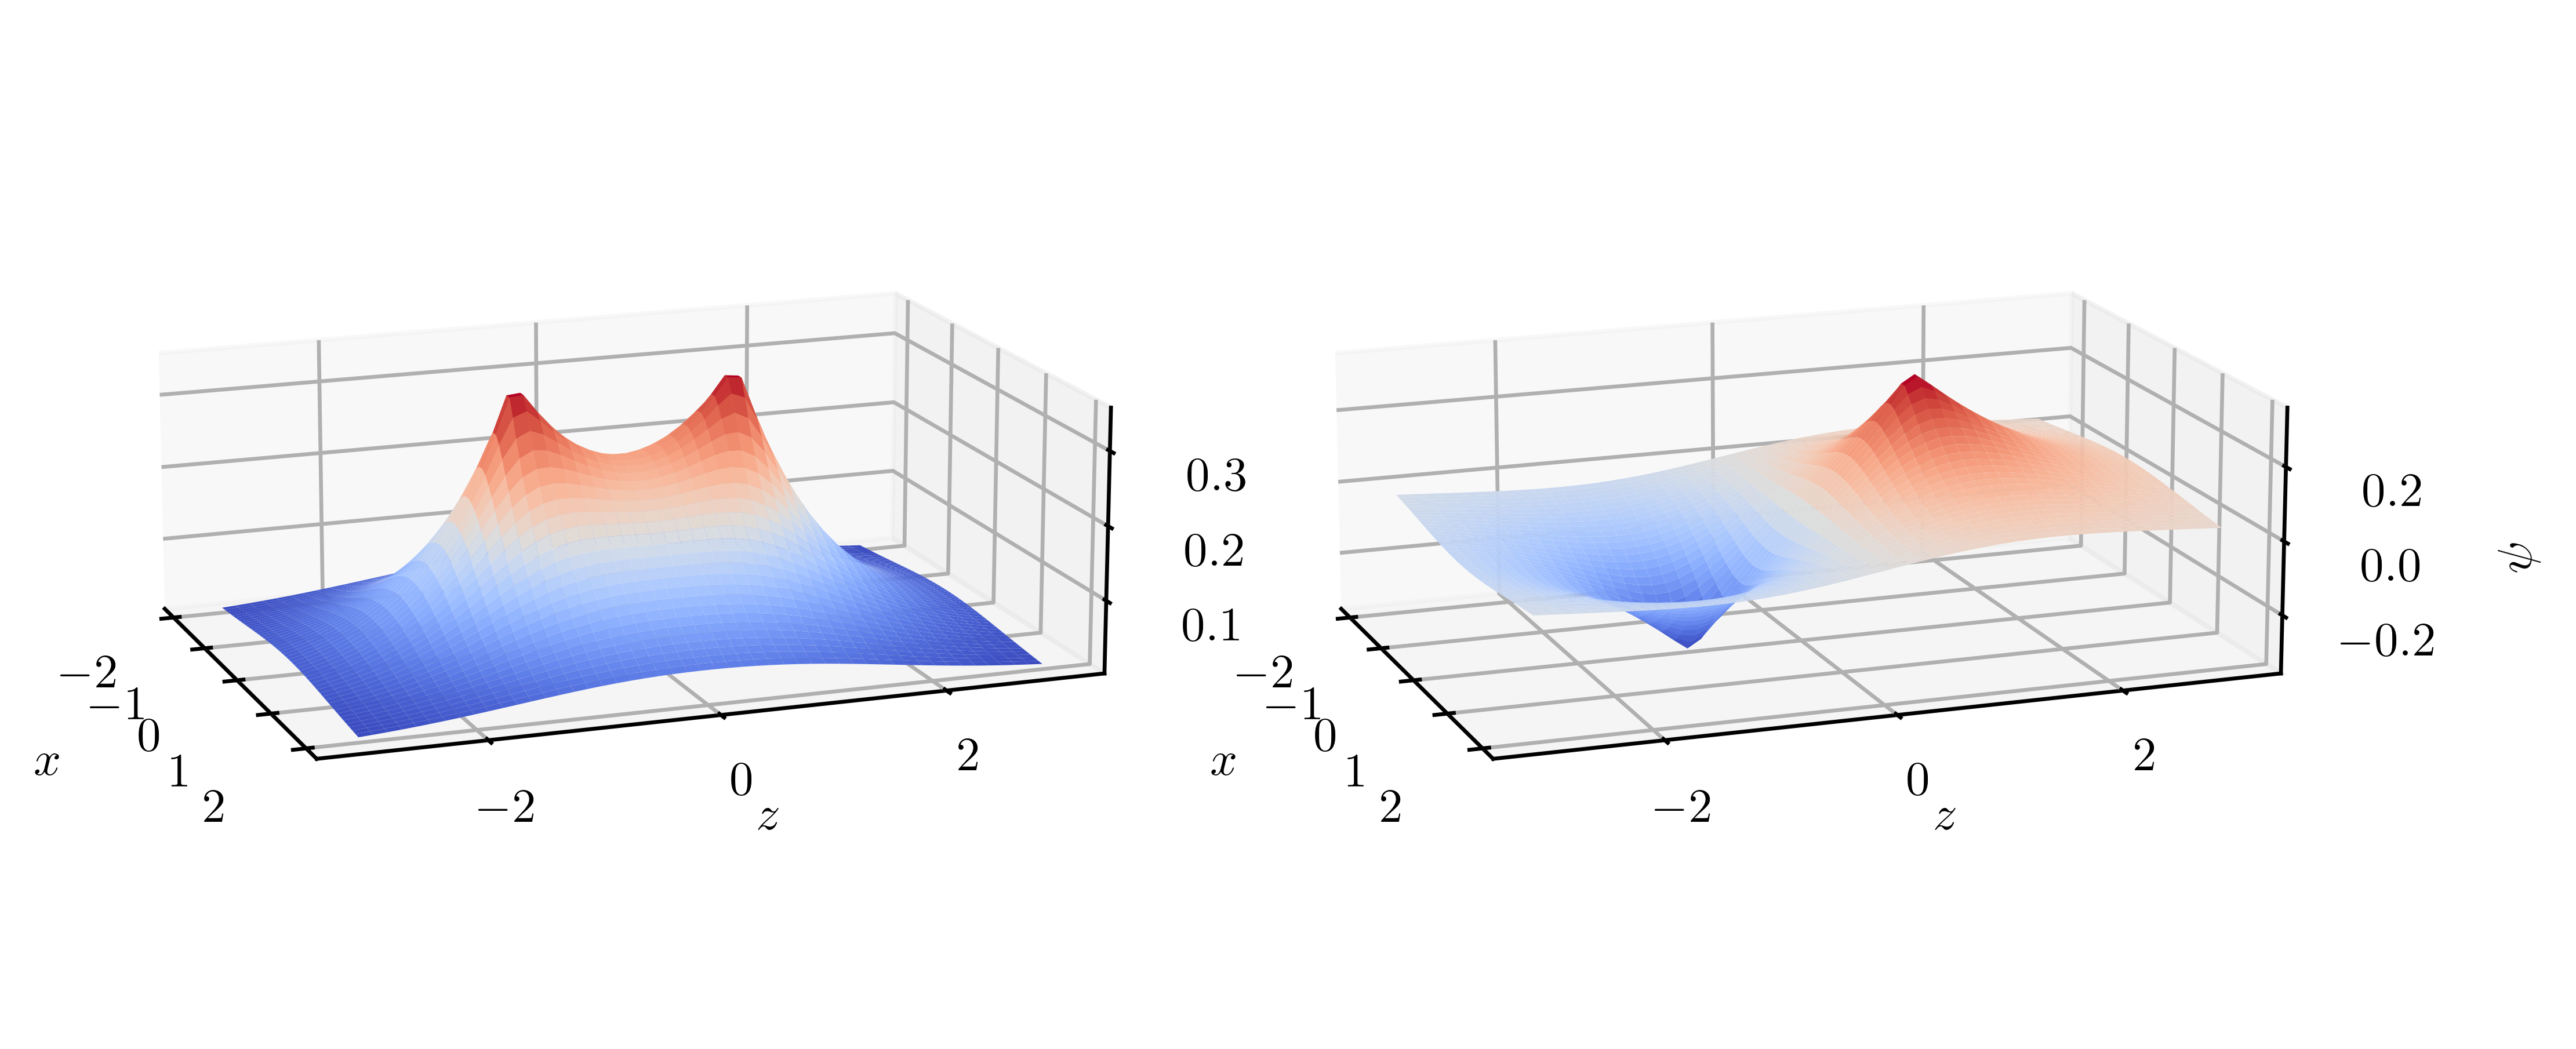

In [3]:
# plotting 3D contour plots

from matplotlib import cm

# given an l, return notation for E_exact_dict
mo_notations = ['1 sigma g', '1 sigma u *']

fig, axes = plt.subplots(1, 2, subplot_kw={"projection":'3d'})

mo_slices = []

for l, mo_notation in enumerate(mo_notations):
    mo_slice = np.vectorize(get_mo_slice(l, E_exact_dict[mo_notation]))
    mo_slices.append(mo_slice)
    
    X = np.linspace(-2.0, 2.0, 50)
    Z = np.linspace(-3.0, 3.0, 50)
    X, Z = np.meshgrid(X, Z)
    PSI = mo_slice(X, Z)
    im = axes[l].plot_surface(X, Z, PSI, cmap=cm.coolwarm)
    axes[l].set_xlabel('$x$')
    axes[l].set_ylabel('$z$')
    axes[l].set_zlabel('$\psi$')
    axes[l].set_box_aspect((2, 3, 1))
    axes[l].view_init(elev=15, azim=-20)

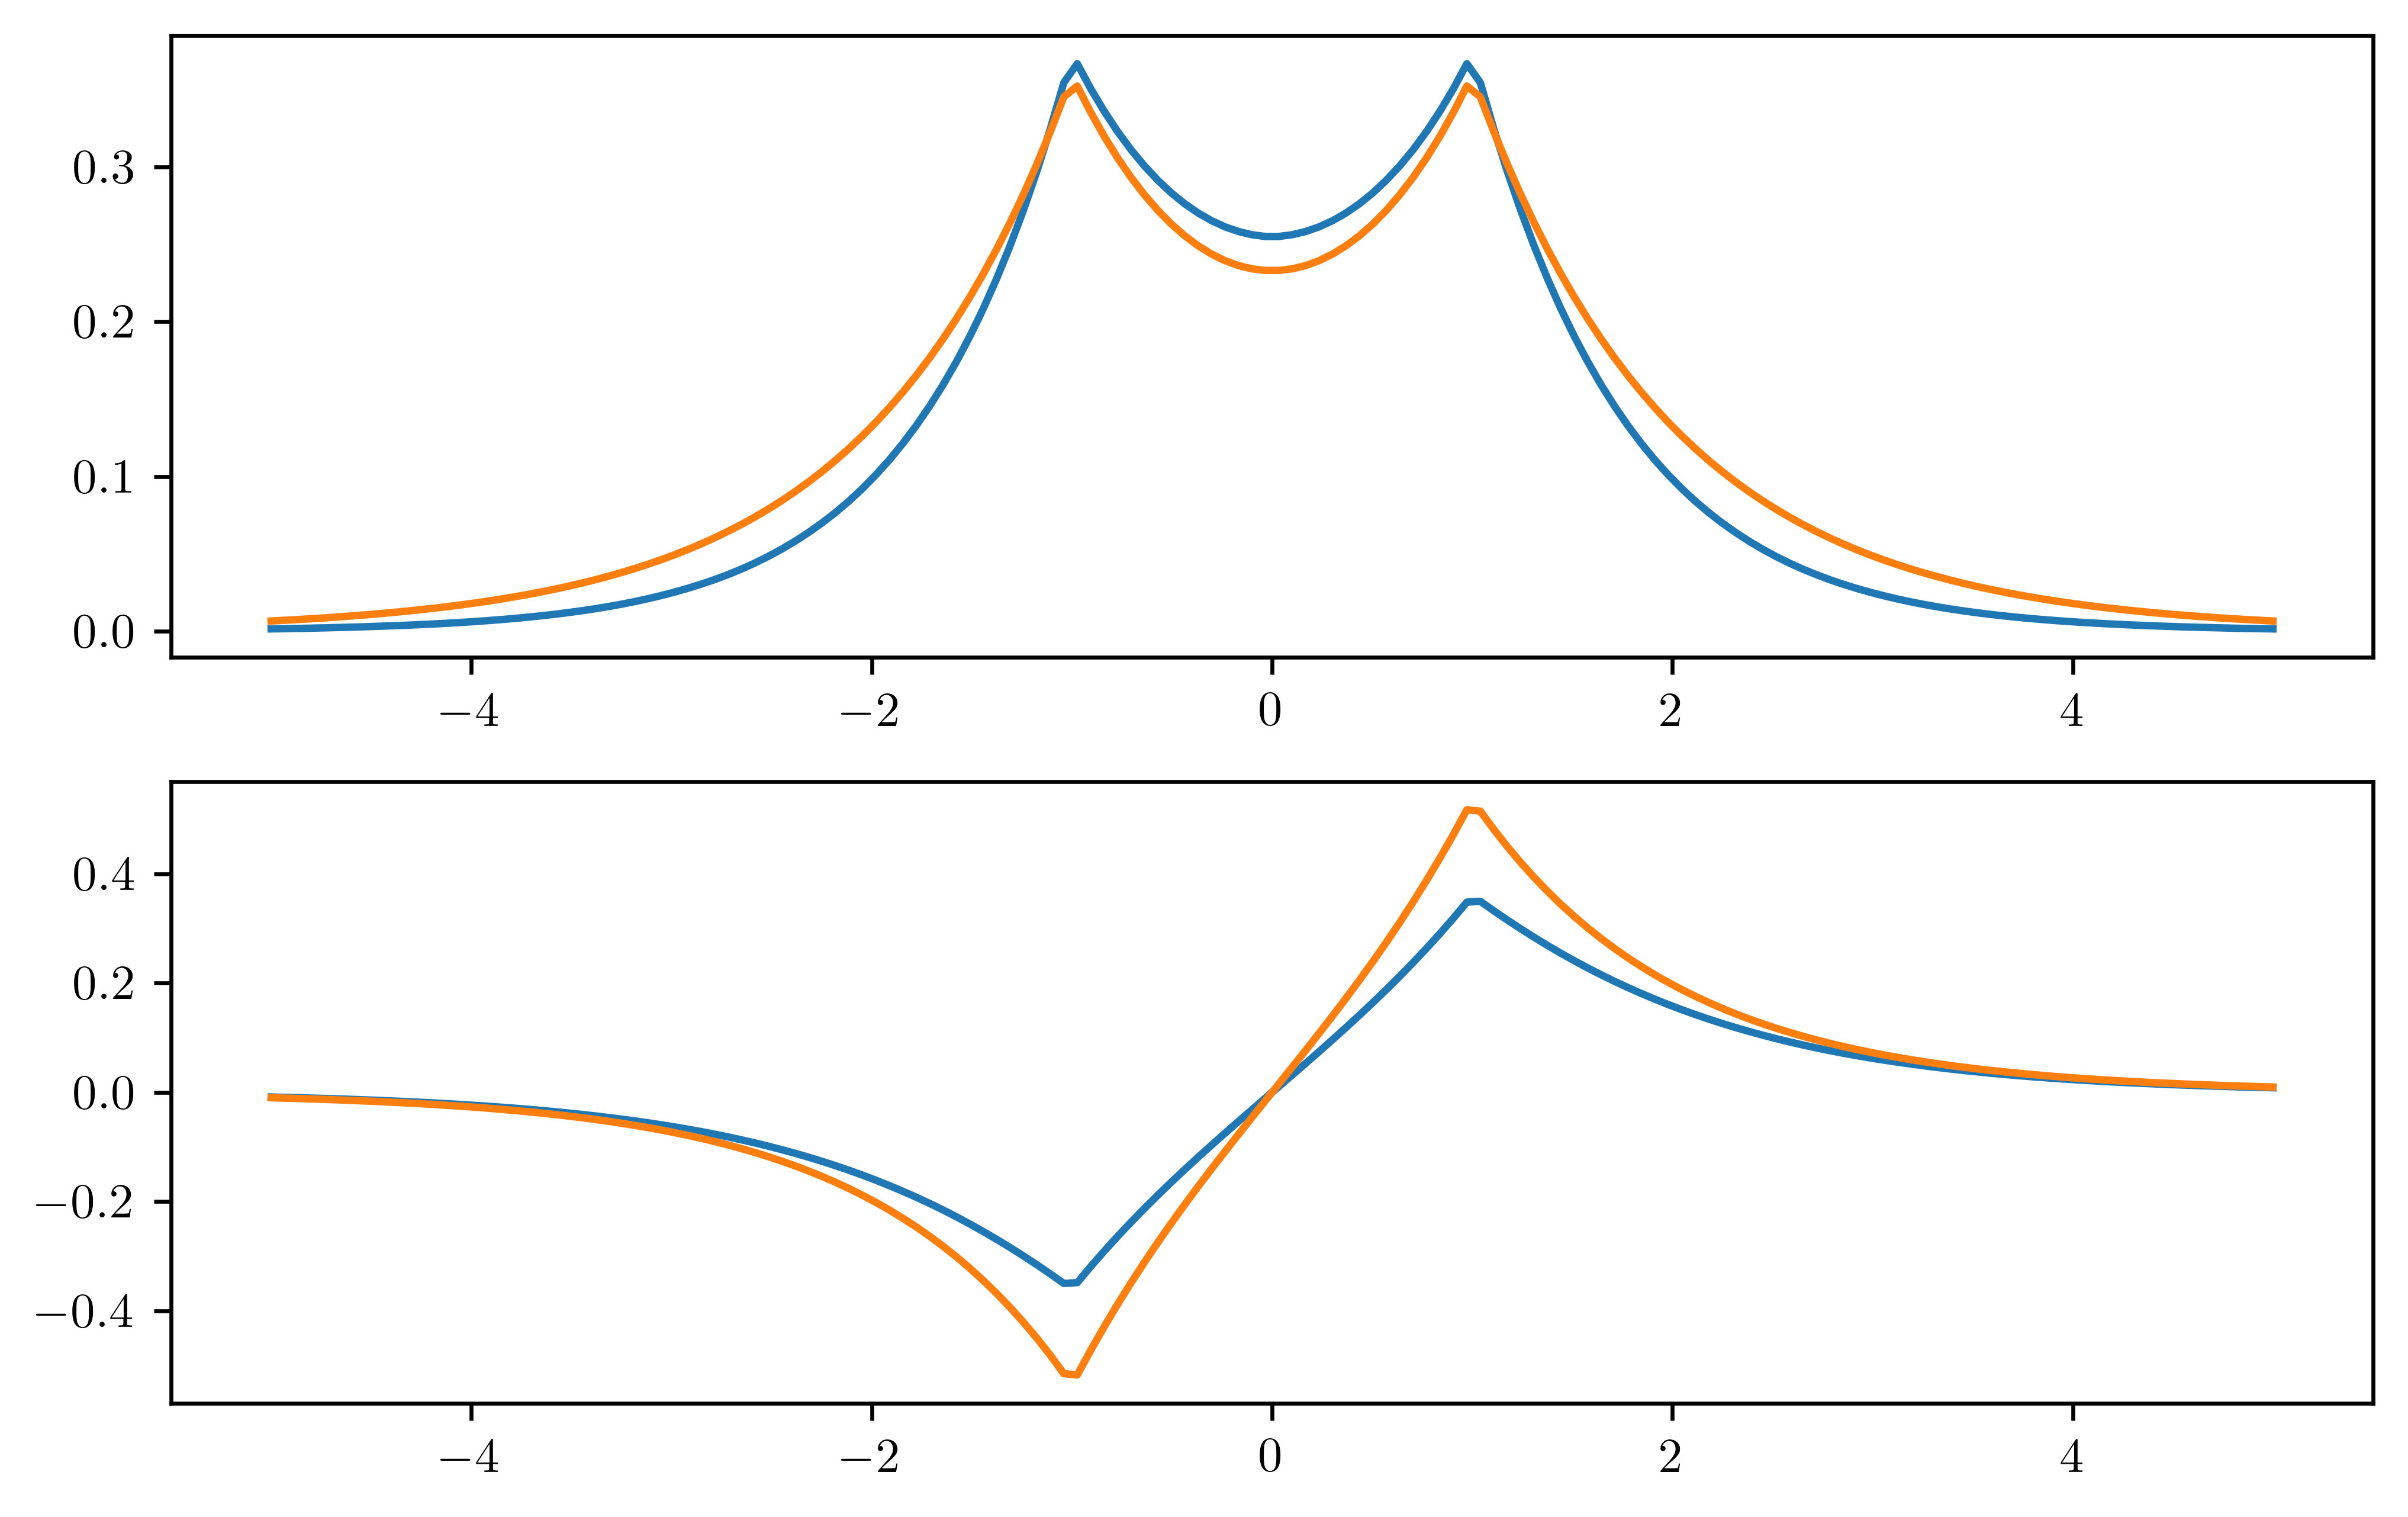

In [4]:
# cutaway

z_span = np.linspace(-5, 5, 150)

fig, axes = plt.subplots(2, 1)

for l in range(2):
    mo_z = np.vectorize(lambda z: mo_slices[l](0, z))
    axes[l].plot(z_span, mo_z(z_span))
    lcao_slice = get_lcao_slice(l)
    lcao_z = np.vectorize(lambda z: lcao_slice(0, z))
    axes[l].plot(z_span, lcao_z(z_span))
    



### The Shapes of Orbitals

1. Code random scatterplot
2. Code isosurface drawing

### Scatterplot



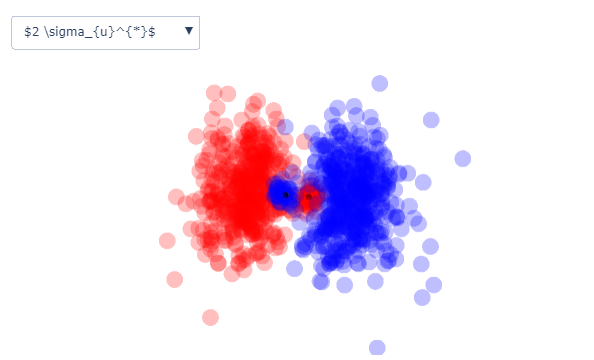

In [45]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'jupyterlab'
# pio.renderers.default = 'browser'

mo_notations = [
    '1 sigma g',
    '1 sigma u *',
    '1 pi u',
    '2 sigma g',
    '2 sigma u *',
    '3 sigma g',
    '1 pi g *',
    '3 sigma u *',
]

mo_latex = {
    '1 sigma g': r"$1 \sigma_{g}$",
    '1 sigma u *': r"$1 \sigma_{u}^{\ast}$",
    '1 pi u': r"$1 \pi_{u}$",
    '2 sigma g' : r"$2 \sigma_{g}$",
    '3 sigma g' : r"$3 \sigma_{g}$",
    '2 sigma u *' : r"$2 \sigma_{u}^{*}$",
    '1 pi g *' : r"$1 \pi_{g}^{*}$",
    '3 sigma u *' : r"$3 \sigma_{u}^{*}$",
}

mo_range = {
    '1 sigma g': 2,
    '1 sigma u *': 3,
    '1 pi u': 6,
    '2 sigma g': 7,
    '2 sigma u *': 8,
    '3 sigma g': 9,
    '1 pi g *': 9,
    '3 sigma u *': 15,
}

opacity = 0.25
sample_size = 1000

# y, z, x
fig = go.Figure()



fig.update_layout(
    template='plotly_white',
    margin=dict(l=5, r=5, t=5, b=5),
    height = 500,
    showlegend=False,
    scene = dict(
        xaxis_visible=False,
        yaxis_visible=False,
        zaxis_visible=False,
    )
)

buttons = []

for ind, mo_notation in enumerate(mo_notations):
    n, mu, l = mo_nums[mo_notation]
    
    # retrieve Lambda from file
    filename = f"data_scatter/samples_{n}{mu}{l}.npy"
    filedir = os.path.join(os.path.abspath(''), filename)
    samples_loaded = np.load(filedir)

    points = samples_loaded[:sample_size, :3]
    points_sign = samples_loaded[:sample_size, 3].astype(bool)

    pos_points = points[points_sign, :]
    neg_points = points[np.logical_not(points_sign), :]
    
    init_visible = True if ind == 0 else False
    
    fig.add_trace(
        go.Scatter3d(
            visible=init_visible,
            x=pos_points[:, 1], 
            y=pos_points[:, 2], 
            z=pos_points[:, 0],
            mode='markers',
            marker=dict(
                size=5,
                color='red',                
                opacity=opacity
            )
        )
    )
    fig.add_trace(
        go.Scatter3d(
            visible=init_visible,
            x=neg_points[:, 1], 
            y=neg_points[:, 2], 
            z=neg_points[:, 0],
            mode='markers',
            marker=dict(
                size=5,
                color='blue',                
                opacity=opacity
            )
        )
    )
    
    button = dict(
        label=mo_latex[mo_notation],
        method='update',
        args=[{'visible': [False] * 17}])
    
    button['args'][0]['visible'][-1] = True
    button['args'][0]['visible'][2*ind] = True
    button['args'][0]['visible'][2*ind+1] = True
    buttons.append(button)

fig.add_trace(
    go.Scatter3d(
        x=[0, 0],
        y=[-1, 1],
        z=[0, 0],
        mode='markers',
        marker=dict(
            size=2,
            color='black',
            opacity=1.0
        )
    )
)
    
fig.update_traces(
    hoverinfo='skip',
    showlegend=False
)
    
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.01,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ]
)



fig.update_layout(
    scene = dict(
        xaxis = dict(range=[-24, 24]),
        yaxis = dict(range=[-40, 40]),
        zaxis = dict(range=[-24, 24]),
        aspectratio=dict(x=24, 
                         y=40, 
                         z=24,),
        camera=dict(eye=dict(x=25, y=3.0, z=3.0))))


"""

_range = mo_range[mo_notation] * 1.7
ranges = [[-_range*0.7, _range*0.7], 
          [-_range*0.7, _range*0.7], 
          [-_range, _range]]



fig.update_layout(
    scene = dict(
        xaxis = dict(range=ranges[1]),
        yaxis = dict(range=ranges[2]),
        zaxis = dict(range=ranges[0]),
        aspectratio=dict(x=(ranges[1][1] - ranges[1][0]), 
                         y=(ranges[2][1] - ranges[2][0]), 
                         z=(ranges[0][1] - ranges[0][0]),),
        camera=dict(eye=dict(x=_range*3.5, y=3.0, z=3.0))))

"""
fig.show()
